Loading modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import textwrap

Following section tidy data and creates data iterator . Dont mess with it.

In [ ]:
import sys
from unicodedata import category
codepoints = range(sys.maxunicode + 1)
punctuation = {chr(i) for i in codepoints if category(chr(i)).startswith("P")}
punctuation.remove("’")

In [ ]:
f = open("Book 1 - The Philosopher's Stone.txt",encoding="utf8")   # Please write path of book accordingly.
l = f.read()
f.close()


In [ ]:
a = l

In [ ]:
b = a.split('\n\n')

In [ ]:
len(b)  

4165

In [ ]:
c = []

In [ ]:
for i in range(len(b)):
    b[i] = b[i].strip()

In [ ]:
flag=0
for i in range(1,len(b)-1):
    if b[i].isupper()==0 and flag<=0:
        if b[i].find('Page | ')==0:
            if b[i-1] != '' and b[i-1][-1] != '.':
                temp = " ".join([b[i-1],b[i+1]])
                c.append(temp.replace('\n','').lower())
                flag = 1
        elif flag<=0:
            c.append(b[i].replace('\n','').lower())
    flag-=1

In [ ]:
for i in range(len(c)):
    ind = c[i].find('page | ')
    if ind!=-1:
        c[i] = c[i][:ind]

In [ ]:
d = []
for i in c:
    if i!='':
        d.append(i)

In [ ]:
d[:100]

['mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much. they were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense.',
 'mr. dursley was the director of a firm called grunnings, which made drills. he was a big, beefy man with hardly any neck, although he did have a very large mustache. mrs. dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. the dursley s had a small son called dudley and in their opinion there was no finer boy anywhere.',
 'the dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. they didn’t think they could bear it if anyone found out about the potters. mrs. potter was mrs. dursley’s sister, but they hadn’t',
 'the du

In [ ]:
words = []

In [ ]:
data2 = []

for i in d:
    a = []
    temp = i.strip()
    word = ''
    j = 0
    while j<len(temp):
        if temp[j]==' ':
            a.append(word.lower())
            word = ''
        elif temp[j] in punctuation:
            if word != '':
                a.append(word.lower())
            a.append(temp[j])
            word = ''
            
        else:
            word += temp[j]
        j +=1 
    if len(word) != 0:
        a.append(word.lower())
    if a[-1] != '\n':
        a.append('\n')
    data2.append(a)

In [ ]:
data = []
for i in range(len(data2)):
    while data2[i].count('')!=0:
        data2[i].remove('')

In [ ]:
len(data2)   # Number of paragraphs.

3275

In [ ]:
word_dict2 = {}
index = 0
for i in data2:
    for j in i:
        if j not in word_dict2:
            word_dict2[j] = index
            index+=1
rev_word_dict2 = {}
for i in word_dict2:
    rev_word_dict2[word_dict2[i]] = i

In [ ]:
len(word_dict2)   # Number of distinct words.

5978

dataset is ready

data2 carries all training data . Try printing data2[:10] to get idea

word-dict2 is dictionary that assigns words thier respective index

rev_word_dict2 is dictionary that assigns indexes their respective indexes

Following encodings2 function tokenizes paragraphs based on word_dict2

In [ ]:
def encodings2(sentence,word_dict2):
    vocab_size = len(word_dict2)
    input_size = len(sentence)
    one_hot_sentence = torch.zeros([input_size-1],dtype=torch.long)
    target = torch.zeros([input_size-1],dtype=torch.long)

    for i in range(len(sentence)-1):
        word = sentence[i]
        next_word = sentence[i+1]
        one_hot_sentence[i] = word_dict2[word]
        target[i] = word_dict2[next_word]
    #print(one_hot_sentence.shape,target.shape)
    return(one_hot_sentence,target)

In RNN class you can change LSTM layer with RNN or GRU layers

In [ ]:
class RNN(nn.Module):
    def __init__(self,hidden_size,output_size,vocab_size,embedding,num_layers):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.emb = embedding
        self.embedding = nn.Embedding(vocab_size,embedding)
        self.lstm = nn.LSTM(embedding,hidden_size,batch_first=True,num_layers=num_layers)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size,output_size)
    def forward(self,x,hidden,cell):
        x = self.embedding(x)
        x = x.reshape(1,x.shape[0],x.shape[1])
        x,(hidden,cell) = self.lstm(x,(hidden,cell))
        x = self.dropout(x)
        x = self.fc(x)
        return(x,(hidden,cell))
    def initHidden(self):
        return(torch.zeros([self.num_layers,1,self.hidden_size]))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
embedding = 128
output_size = vocab_size = len(word_dict2)
hidden_size = 256
num_layers = 4
learning_rate = 0.0006
epochs = 25

In [ ]:
model2 = RNN(hidden_size,output_size,vocab_size,embedding,num_layers).to(device)
optimizer = optim.Adam(model2.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model2):,} trainable parameters')

The model has 4,275,802 trainable parameters


**Training** 


---
 Training takes approx 25 sec per epochs and run for 25 epochs to get best 
results.

In [ ]:
loss_lst = []
for epoch in range(5):  # epochs
    epoch_loss = []
    t1 = time.time()
    for sentence in data2:
        if(len(sentence)==1):
            continue
        sentence_encoding,target = encodings2(sentence,word_dict2)
        sentence_encoding = sentence_encoding.to(device)
        target = target.to(device)
        #print(sentence_encoding)
        #print(target.shape)
        hidden = model2.initHidden().to(device)
        cell = model2.initHidden().to(device)
        #print(cell.shape)
        model2.zero_grad()
        optimizer.zero_grad()

        out,(hidden,cell) = model2(sentence_encoding,hidden,cell)
        #print(out.shape)
        out = out.reshape(-1,output_size)
        loss = criterion(out,target)
        epoch_loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1)
        optimizer.step()
    loss_lst += epoch_loss
    t2 = time.time()
    print("mean epoch loss : {}  ||  mean loss till now : {}  ||  time : {}".format(np.mean(epoch_loss),np.mean(loss_lst),t2-t1))

mean epoch loss : 1.409610965297312  ||  mean loss till now : 1.409610965297312  ||  time : 25.2511465549469
mean epoch loss : 1.37460290232283  ||  mean loss till now : 1.392106933810071  ||  time : 25.319092512130737
mean epoch loss : 1.333859706474893  ||  mean loss till now : 1.3726911913650115  ||  time : 25.293903589248657
mean epoch loss : 1.3002220505569175  ||  mean loss till now : 1.3545739061629882  ||  time : 25.24527859687805
mean epoch loss : 1.2684122084095975  ||  mean loss till now : 1.3373415666123099  ||  time : 25.25169062614441


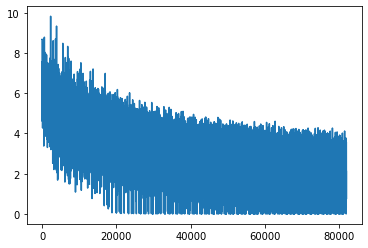

In [ ]:

plt.plot(loss_lst)

In [ ]:
torch.save(model2.state_dict(),'wordRNN_paragraph_lstm2.pth')    # saving the model.

If you are not interested in training, you can directly load by runnung following command. Kindly write the path of file accordingly.

In [ ]:
model2.load_state_dict(torch.load('wordRNN_paragraph_lstm2.pth'))
# embedding = 128
# output_size = vocab_size = len(word_dict2)
# hidden_size = 256
# num_layers = 4
# learning_rate = 0.0006
# epochs = 25 
# loss = 1.5 best perfomance till now.

<All keys matched successfully>

**Testing**

testing2 function will be called below for generating paragraphs in continuation  with given data

In [ ]:
def testing2(sentence):
    sentence = sentence.strip()
    sample = sentence
    word = sentence.split()[-1]
    word_encoding = torch.tensor([word_dict2[word]]).to(device)
    

    if len(sentence.split()) >= 2:
        if len(sentence.split()) == 2:
            sentence_encoding = torch.tensor([word_dict2[sentence.split()[0]]]).to(device)
        else:
            sentence_encoding,target = encodings2(sentence.split()[:-1],word_dict2)
        hidden = model2.initHidden().to(device)
        cell = model2.initHidden().to(device)
        out,(hidden,cell) = model2(sentence_encoding.to(device),hidden,cell)
    
    else:
        hidden = model2.initHidden().to(device)
        cell = model2.initHidden().to(device)
    i=0
    while word != '\n':    
        out,(hidden,cell) = model2(word_encoding,hidden,cell)
        #out = torch.zeros()
        word_index = out.argmax(axis=-1).item()
        word = rev_word_dict2[word_index]
        word_encoding = out.argmax(axis=-1).flatten()
        sample = "{} {}".format(sample,word)
        #print(word)
        i+=1
        if i==80:
            break
    
        
    
    return(sample,i)

In [ ]:
testing2('“ i tell you , we’re going to win that')

('“ i tell you , we’re going to win that in the summer - year waffle , something that he is to die — dumbledore says nothing about it , i’ll therefore nicolas ‘ rude with all with a fifty - points - points points that year , you were steamrollered ! ” \n',
 44)

In [ ]:
testing2('there was a very good chance they were going to get caught')

('there was a very good chance they were going to get caught some point \\ ” \n',
 5)

In [ ]:
testing2('they pulled on their bathrobes , picked up their wands ,')

('they pulled on their bathrobes , picked up their wands , insisting themselves , and snape into the slytherin table . “ aren’t you ? ” screeched dumbledore , but she passed , but mr . dursley was , mysterious a long bite with broad soon \n',
 36)

In [ ]:
testing2('“ i am scared ”')

('“ i am scared ” . . . for the soul . “ i can knew it , ” said dumbledore , grinning , grinning down the mom , “ mom , mom . ” \n',
 31)

In [ ]:
testing2('hermione took out a list of subjects and titles she had')

('hermione took out a list of subjects and titles she had found talking to the ceiling . harry found a quiver again at the barrier , but the whisperers bear the platform as dressed there , too . \n',
 28)

In [ ]:
testing2('good')

('good day to you . ” \n', 6)

After 5 more epochs performance degrades

In [ ]:
testing2('“ i tell you , we’re going to win that')

('“ i tell you , we’re going to win that a muggle , ” said ron , grinning around to the fleet . “ i pomfrey i’ll be taken out ter be a window . ” \n',
 27)

In [ ]:
testing2('there was a very good chance they were going to get caught')

('there was a very good chance they were going to get caught ron outside , because it was still talking about down yet . \n',
 13)

In [ ]:
testing2('they pulled on their bathrobes , picked up their wands ,')

('they pulled on their bathrobes , picked up their wands , and coats - faced ; cloudy down into the window , ‘ the table were scarlet and a terrible hangings like up . at one seat serpent facedown into a table , invisible flames quirrell lost . “ useful owls . ” \n',
 43)

In [ ]:
testing2('“ i am scared ”')

('“ i am scared ” . . . for the stone , i award gryffindor house fifty points . ” \n',
 16)

In [ ]:
testing2('hermione took out a list of subjects and titles she had')

('hermione took out a list of subjects and titles she had still look forward down to a muggle , letting slytherin , he felt snape a thick points off to contact as the fun of magic , because she said resting , “ that’s forget to say — i award ron change , dear — to be four happy . . . . ” \n',
 54)

In [ ]:
testing2('good')

('good day to you . ” \n', 6)